This notebooks presents the chronic lymphocytic leukemia (CLL) dataset analysis using `muon`.

[This dataset and its detailed analysis are described in an R notebook here](http://htmlpreview.github.io/?https://github.com/bioFAM/MOFA2_tutorials/blob/master/R_tutorials/CLL.html).

In [1]:
import scanpy as sc
import muon as mu
import numpy as np
import pandas as pd
import mofax as mofa

In [2]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 150

# Load data

In [3]:
data_dir = "data/CLL"

Metadata:

In [4]:
obs = pd.read_csv(f"{data_dir}/metadata.tsv", sep="\t", index_col='sample')

Matrices with data:

In [5]:
data_dir = "data/CLL"
mods = {i:sc.AnnData(pd.read_csv(f"{data_dir}/{i}.csv", index_col=0).T) for i in ("drugs", "methylation", "rna", "mutations")}

In [6]:
mdata = mu.MuData(mods)
mdata.obs = mdata.obs.join(obs)

In [7]:
mdata

MuData object with n_obs × n_vars = 200 × 9627
  obs:	'Gender', 'age', 'TTT', 'TTD', 'treatedAfter', 'died', 'IGHV_status', 'trisomy12'
  4 modalities
    drugs:	184 x 310
    methylation:	196 x 4248
    rna:	136 x 5000
    mutations:	200 x 69

# Integrate data

Multi-omics factor analysis integration can be run on a MuData object with a single command:
 
```
mu.tl.mofa()
```

In case some samples are missing from some of the modalities, as they are in this CLL data, `muon` will handle that for you. One of two modes has to be chosen for that:

1. `use_obs='union'`, which will populate values for missing samples in certain modalities with NAs, or

1. `use_obs='intersection'`, which will use a subset of samples that are present in all modalities.

In [8]:
mu.tl.mofa(mdata, use_obs='union', 
           n_factors=15, outfile="models/CLL_union.hdf5")


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='drugs' group='group1' with N=200 samples and D=310 features...
Loaded view='methylation' group='group1' with N=200 samples and D=4248 features...
Loaded view='rna' group='group1' with N=200 samples and D=5000 features...
Loaded view='mutations' group='group1' with N=200 samples and D=69 features...


Model options:
- Automatic Relevance Determination prior on the fa

We can see that the model has been trained successfully and has managed to learn some meaningful structure in the data:

... storing 'Gender' as categorical
... storing 'treatedAfter' as categorical
... storing 'died' as categorical


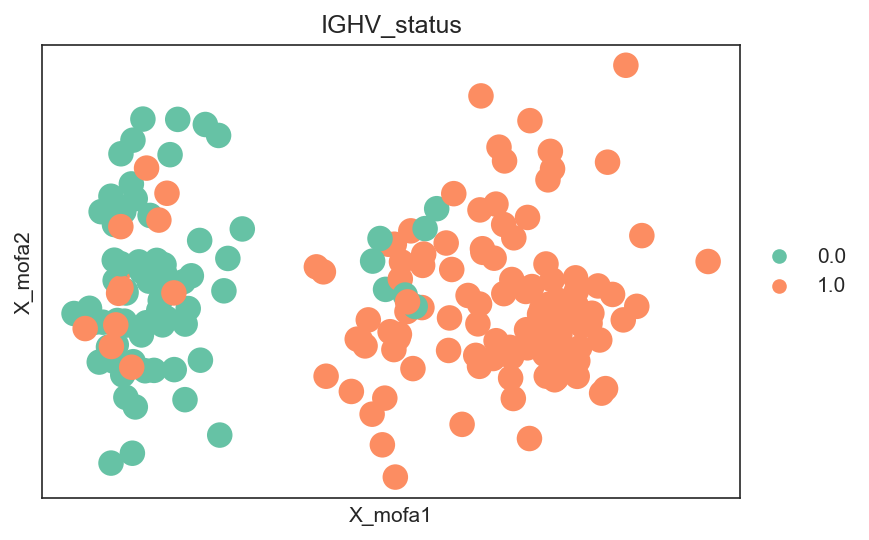

In [9]:
mdata.obs.IGHV_status = mdata.obs.IGHV_status.astype('category')
mu.pl.mofa(mdata, color="IGHV_status")

# Interpret intergrated data

In [10]:
model = mofa.mofa_model("models/CLL_union.hdf5")
model

MOFA+ model: CLL union
Samples (cells): 200
Features: 9627
Groups: group1 (200)
Views: drugs (310), methylation (4248), mutations (69), rna (5000)
Factors: 15
Expectations: W, Z

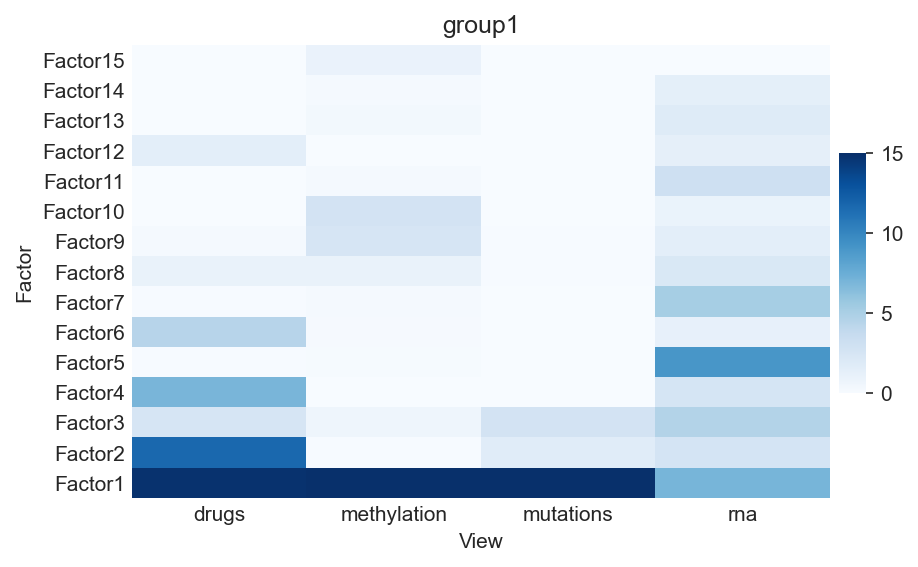

In [11]:
mofa.plot_r2(model, x='View', vmax=15)

We notice e.g. that `Factor 1` captures variability across all modalities, `Factor 2` captures variability across different modalities incl. drug response-specific one, `Factor 5` is quite specific to the RNA modality.

## Factor 1

<AxesSubplot:title={'center':'mutations'}, xlabel='Feature weight'>

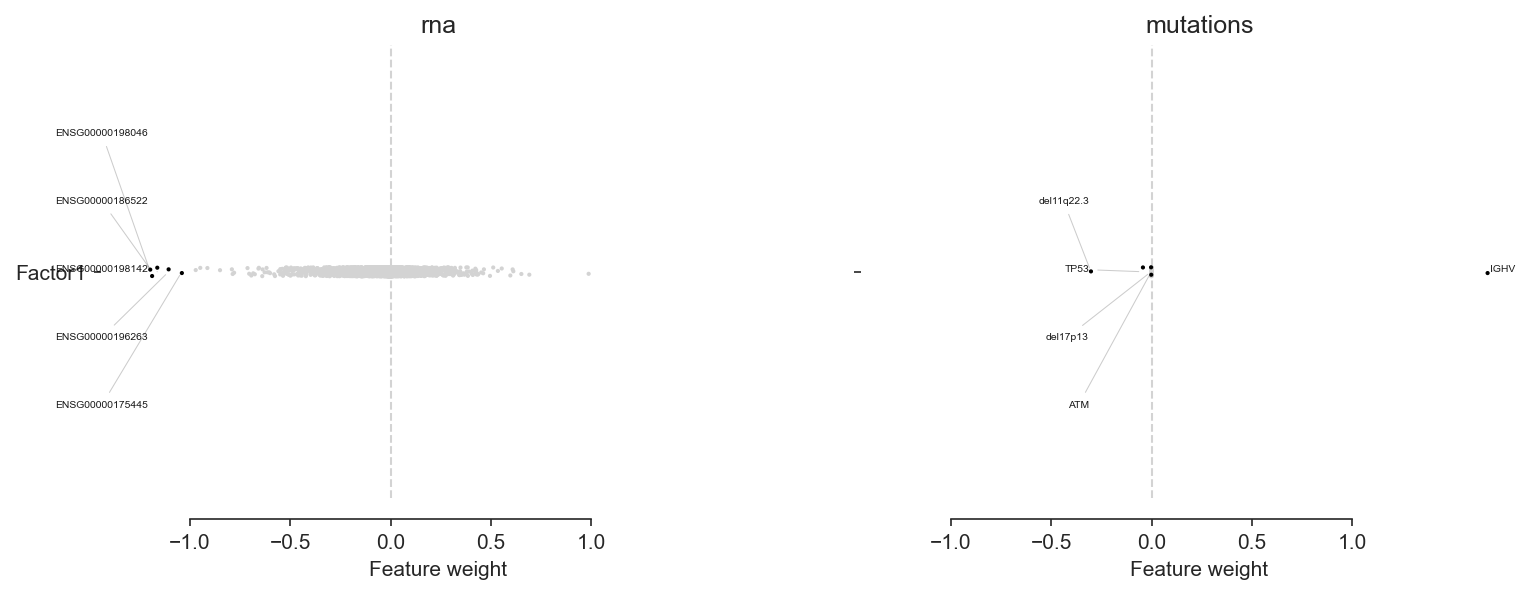

In [12]:
mofa.plot_weights(model, views=['rna', 'mutations'], factors=0, zero_line=True, ncols=2)

We can see that top weights from the RNA modality make sense and are likely to represent the same latent process as IGHV status:

- ENSG00000198046 &rarr; ZNF667 — lnc‐ZNF667‐AS1 [is associated with poor survival and is a promising prognostic biomarker](https://onlinelibrary.wiley.com/doi/abs/10.1111/ijlh.13167)

- ENSG00000186522 &rarr; SEPT10 – its expression [correlates with IGHV status](https://www.nature.com/articles/2404220) (however [there are some caveats](https://www.nature.com/articles/2404867))

- ENSG00000198142 &rarr; SOWAHC – it [has been identified as a prognostic marker for other cancers](https://www.spandidos-publications.com/mmr/21/3/1285)

In [13]:
model.metadata.IGHV_status = model.metadata.IGHV_status.astype(str).astype('category').replace({'0.0': '- IGHV', '1.0': '+ IGHV', 'nan': 'NA'})

<AxesSubplot:ylabel='Factor value'>

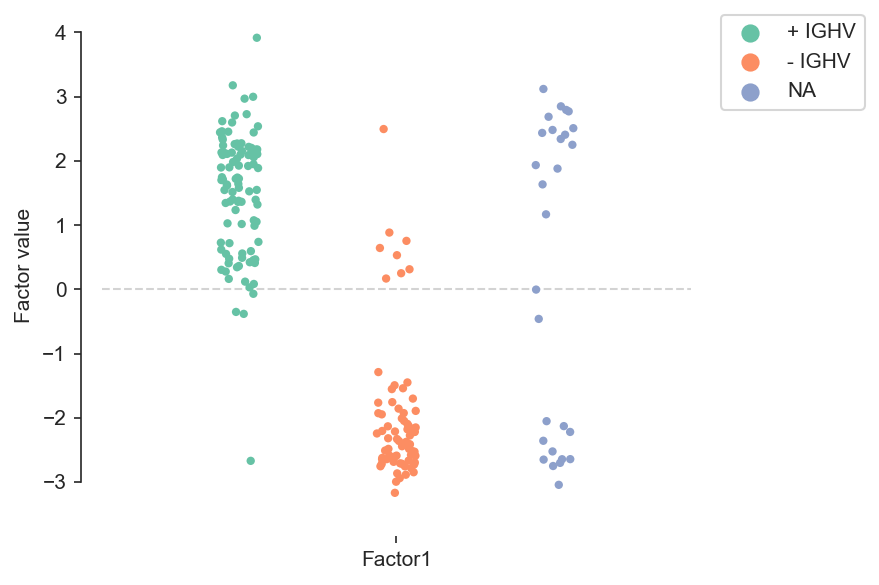

In [14]:
mofa.plot_factors_violin(model, factors=0, dots=True, violins=False, color="IGHV_status")

## Factor 2

<AxesSubplot:title={'center':'mutations'}, xlabel='Feature weight'>

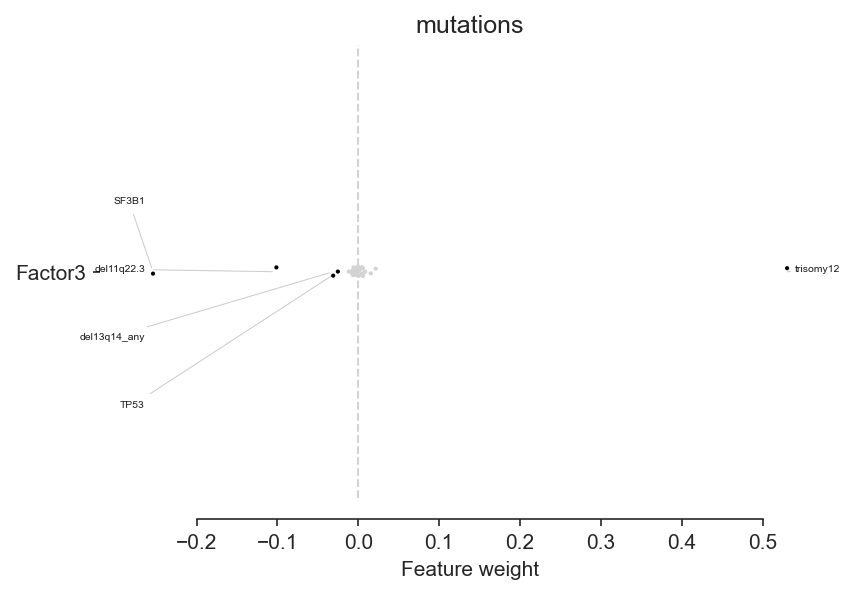

In [15]:
mofa.plot_weights(model, views=['mutations'], factors=2, zero_line=True, ncols=1)

We can see how different the values are for this factor depending on the trisomy12:

<AxesSubplot:ylabel='Factor value'>

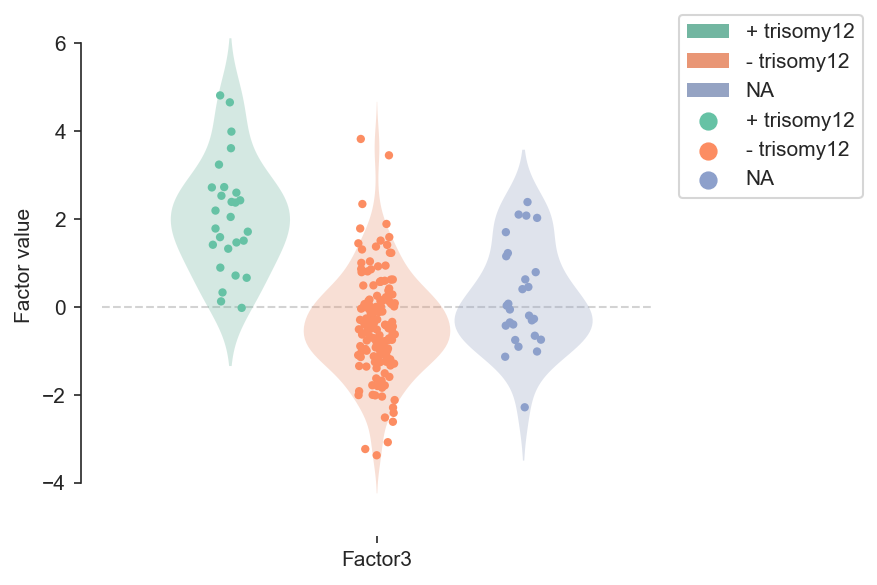

In [16]:
model.metadata.trisomy12 = model.metadata.trisomy12.astype(str).astype('category').replace({'0.0': '- trisomy12', '1.0': '+ trisomy12', 'nan': 'NA'})
mofa.plot_factors_violin(model, factors=2, violins=True, violins_alpha=.3, dots=True, color="trisomy12")

## Factor 5

<AxesSubplot:title={'center':'rna'}, xlabel='Feature weight'>

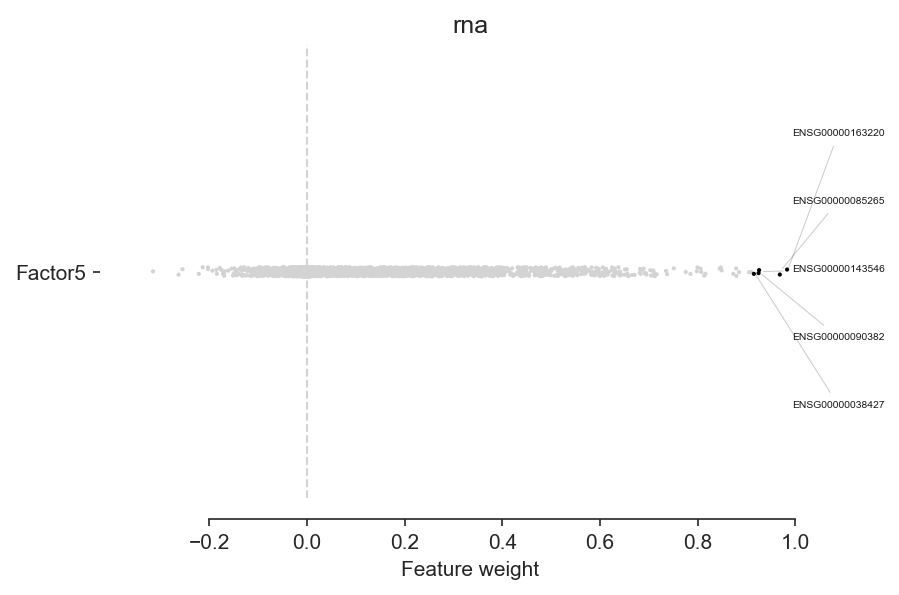

In [17]:
mofa.plot_weights(model, views=['rna'], factors="Factor5", zero_line=True, ncols=2)

We can see that top weights from the RNA modality might be related to myeloid leukemia:

- ENSG00000163220 &rarr; S100A9 — has been found [to be highly expressed e.g. in acute myeloid leukemia (AML)](https://ashpublications.org/blood/article/129/14/1980/35876/S100A9-induces-differentiation-of-acute-myeloid) as well as [to be playing its role in CLL as well](https://ashpublications.org/blood/article/130/6/777/36801/S100-A9-protein-in-exosomes-from-chronic?casa_token=1ZQesYETQxAAAAAA:pVhJx_bh-mfzHhyweYqpzUMK9qJqlO1KcGFvKRiMa3KOlKDlzHadjSginPbA7R99N1wfyw)

- ENSG00000085265 &rarr; FCN1 – [is associated with AML and can be considered as a biomarker](https://www.nature.com/articles/s41598-020-67516-2)

- ENSG00000143546 &rarr; S100A8 – same as S100A9

We, however, do not have clinical covariates related to such sample status in order to corroborate this observation.

<AxesSubplot:title={'center':'IGHV_status'}, xlabel='Factor1 value', ylabel='Factor5 value'>

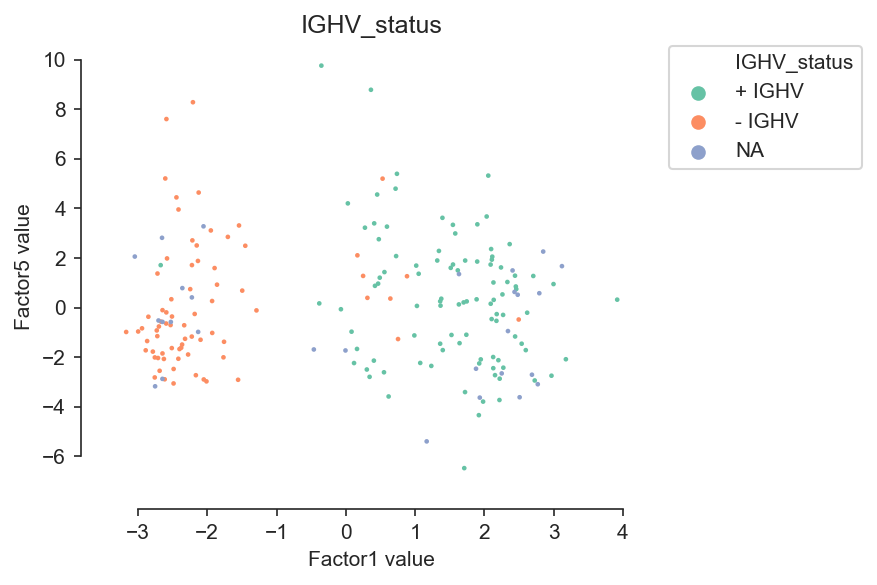

In [18]:
mofa.plot_factors(model, y="Factor5", color="IGHV_status")